# Crosswalk

In [1]:
using AutomotiveDrivingModels
using AutoViz

INFO: Precompiling module AutomotiveDrivingModels.
INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.5/AutoViz.ji for module AutoViz.


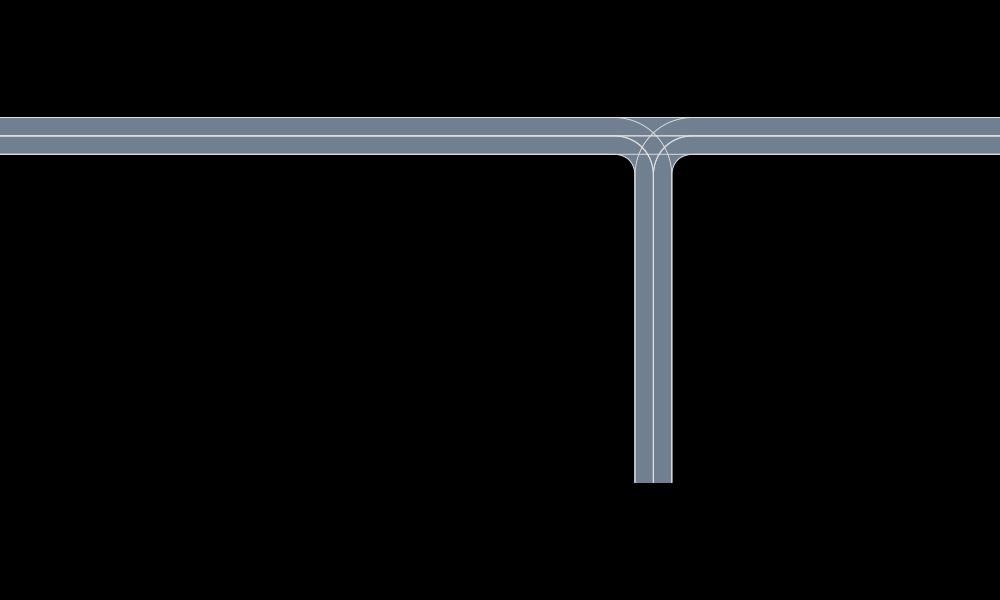

In [2]:
r = 5.0
A = VecSE2(0,DEFAULT_LANE_WIDTH,-π)
B = VecSE2(0,0,0)
C = VecSE2(r,-r,-π/2)
D = VecSE2(r+DEFAULT_LANE_WIDTH,-r,π/2)
E = VecSE2(2r+DEFAULT_LANE_WIDTH,0,0)
F = VecSE2(2r+DEFAULT_LANE_WIDTH,DEFAULT_LANE_WIDTH,-π)

roadway = Roadway()

function append_to_curve!(target::Curve, newstuff::Curve)
    s_end = target[end].s
    for c in newstuff
        push!(target, CurvePt(c.pos, c.s+s_end, c.k, c.kd))
    end
    return target
end

curve = gen_straight_curve(convert(VecE2, B+VecE2(-100,0)), convert(VecE2, B), 2)
append_to_curve!(curve, gen_bezier_curve(B, C, 0.6r, 0.6r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, C), convert(VecE2, C+VecE2(0,-50.0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

curve = gen_straight_curve(convert(VecE2, B+VecE2(-100,0)), convert(VecE2, B), 2)
append_to_curve!(curve, gen_straight_curve(convert(VecE2, B), convert(VecE2, E), 2)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, E), convert(VecE2, E+VecE2(50,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

curve = gen_straight_curve(convert(VecE2, F+VecE2(50,0)), convert(VecE2, F), 2)
append_to_curve!(curve, gen_straight_curve(convert(VecE2, F), convert(VecE2, A), 2)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, A), convert(VecE2, A+VecE2(-100,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

curve = gen_straight_curve(convert(VecE2, F+VecE2(50,0)), convert(VecE2, F), 2)
append_to_curve!(curve, gen_bezier_curve(F, C, 0.9r, 0.9r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, C), convert(VecE2, C+VecE2(0,-50)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

curve = gen_straight_curve(convert(VecE2, D+VecE2(0,-50)), convert(VecE2, D), 2)
append_to_curve!(curve, gen_bezier_curve(D, E, 0.6r, 0.6r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, E), convert(VecE2, E+VecE2(50,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

curve = gen_straight_curve(convert(VecE2, D+VecE2(0,-50)), convert(VecE2, D), 2)
append_to_curve!(curve, gen_bezier_curve(D, A, 0.9r, 0.9r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, A), convert(VecE2, A+VecE2(-100,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

cam = FitToContentCamera(0.0)
render(roadway, cam=cam)

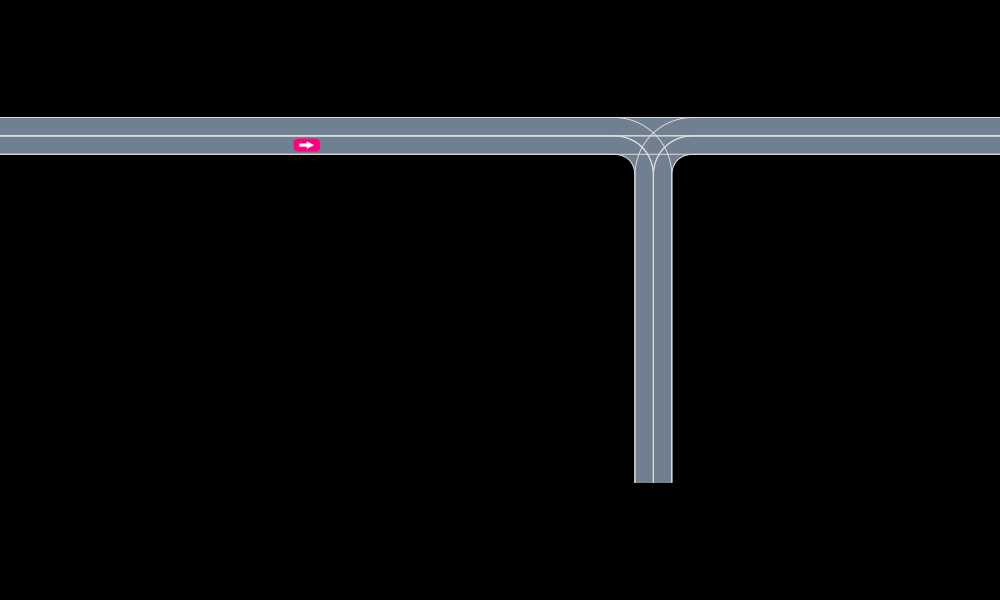

In [3]:
scene = Scene()
push!(scene, Vehicle(VehicleState(B + polar(50.0,-π), roadway, 8.0), VehicleDef(), 1))

render(scene, roadway, cam=cam)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(3, nactions=1),"i",3,"3",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6),Dict(4=>"4",2=>"2",3=>"3",5=>"5",6=>"6",1=>"1")),Any[],Any[],true,"horizontal")

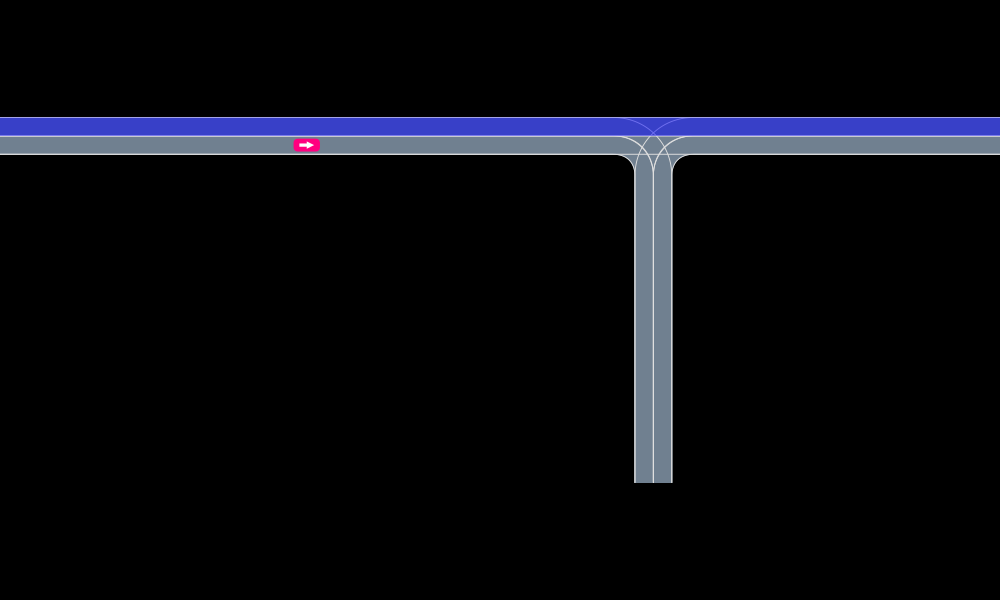

In [4]:
using Interact

type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end

@manipulate for i in 1 : length(roadway.segments)
    render(scene, roadway, [LaneOverlay(roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=cam)
end

In [5]:
immutable LaneSpecificAccelLatLon
    a_lat::Float64
    a_lon::Float64
end
function AutomotiveDrivingModels.propagate(veh::Vehicle, action::LaneSpecificAccelLatLon, roadway::Roadway, Δt::Float64)
    lane_tag_orig = veh.state.posF.roadind.tag
    state = propagate(veh, LatLonAccel(action.a_lat, action.a_lon), roadway, Δt)
    roadproj = proj(state.posG, roadway[lane_tag_orig], roadway, move_along_curves=false)
    retval = VehicleState(Frenet(roadproj, roadway), roadway, state.v)
    return retval
end

type CrosswalkDriver <: DriverModel{LaneSpecificAccelLatLon}
    a::LaneSpecificAccelLatLon
end
AutomotiveDrivingModels.get_name(model::CrosswalkDriver) = "CrosswalkDriver"
Base.rand(model::CrosswalkDriver) = model.a

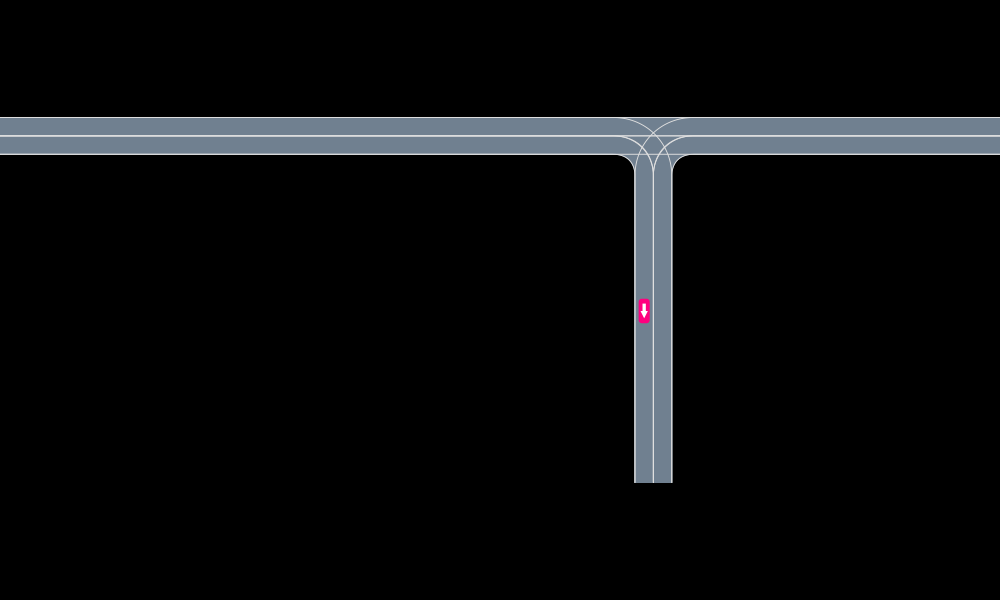

In [6]:
timestep = 0.1

models = Dict{Int, DriverModel}()
models[1] = CrosswalkDriver(LaneSpecificAccelLatLon(0.0,0.0))

nticks = 100
rec = SceneRecord(nticks+1, timestep)
simulate!(rec, scene, roadway, models, nticks)
render(rec[0], roadway, cam=cam)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(51, nactions=1),"frame_index",51,"51",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(68=>"68",2=>"2",89=>"89",11=>"11",39=>"39",46=>"46",85=>"85",25=>"25",55=>"55",42=>"42"…)),Any[],Any[],true,"horizontal")

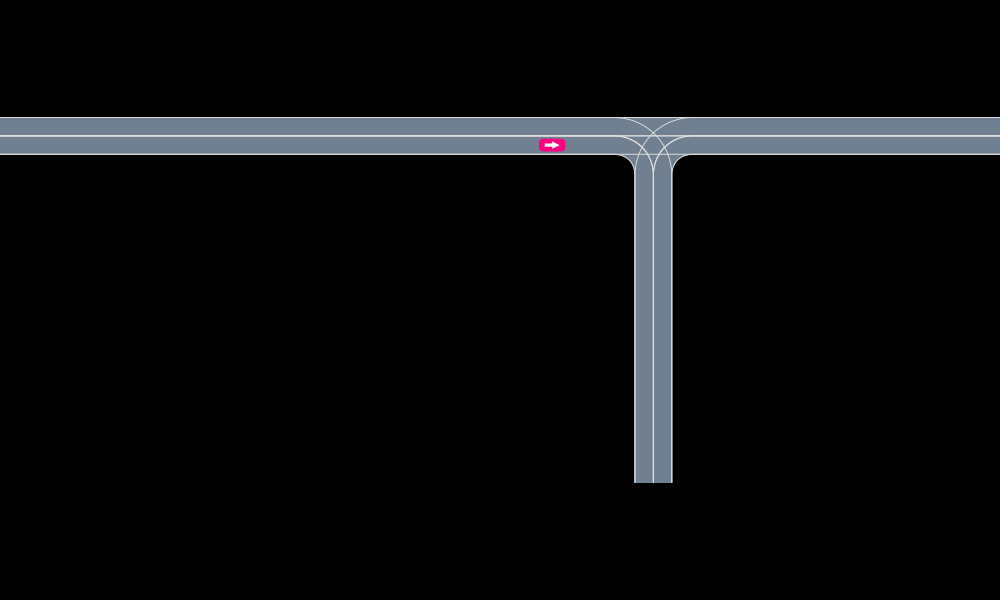

In [7]:
using Interact
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], roadway, cam=cam)
end

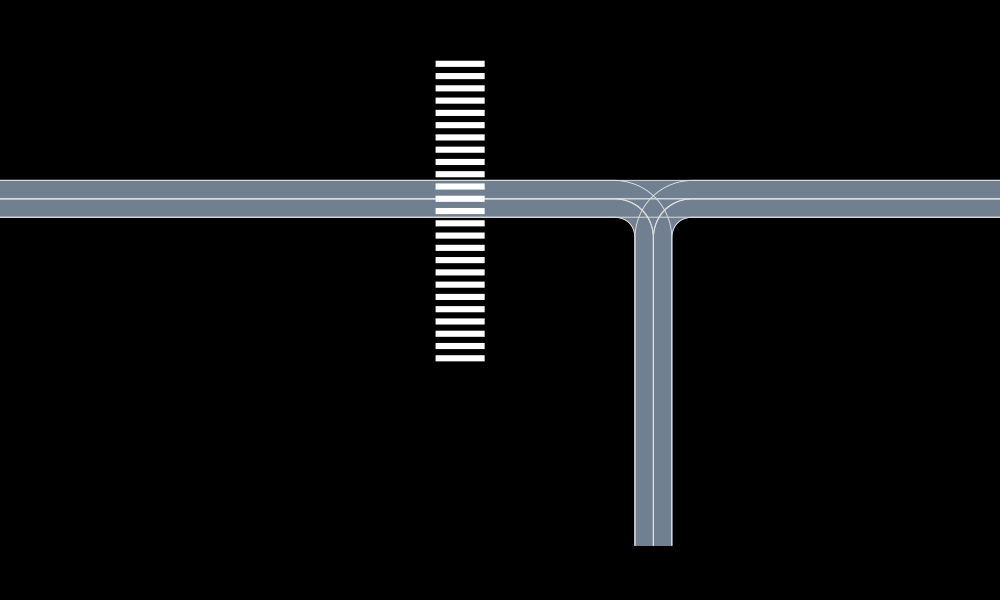

In [8]:
type CrosswalkEnv
    roadway::Roadway
    crosswalk::Lane
end

function AutoViz.render!(rendermodel::RenderModel, env::CrosswalkEnv)
    render!(rendermodel, env.roadway)
    
    curve = env.crosswalk.curve
    n = length(curve)
    pts = Array(Float64, 2, n)
    for (i,pt) in enumerate(curve)
        pts[1,i] = pt.pos.x
        pts[2,i] = pt.pos.y
    end

    add_instruction!(rendermodel, render_dashed_line, (pts, colorant"white", env.crosswalk.width, 1.0, 1.0, 0.0, Cairo.CAIRO_LINE_CAP_BUTT))
    return rendermodel
end

crosswalk = Lane(LaneTag(1,1), gen_straight_curve(VecE2(-25.0, -25.0), VecE2(-25.0, 25.0), 2), width=8.0) 
env = CrosswalkEnv(roadway, crosswalk)
render(env, cam=cam)

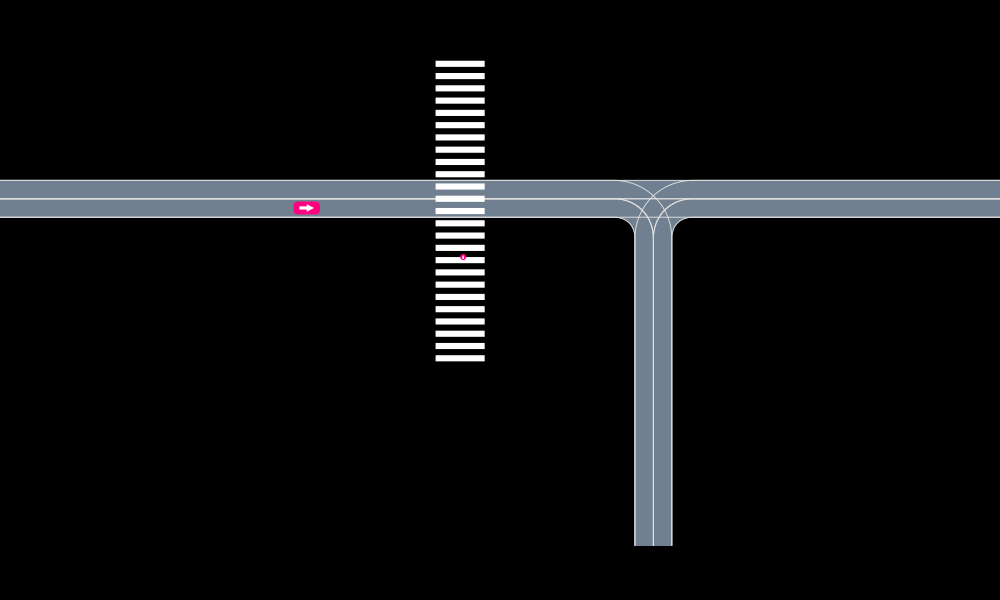

In [9]:
const PEDESTRIAN_DEF = VehicleDef(AgentClass.PEDESTRIAN, 1.0, 1.0)

scene = Scene()
push!(scene, Vehicle(VehicleState(B + polar(50.0,-π), roadway.segments[1].lanes[1],roadway, 8.0), 
             VehicleDef(), 1))
push!(scene, Vehicle(VehicleState(VecSE2(-24.5,-8.0,π/2), env.crosswalk, roadway, 0.5), 
             PEDESTRIAN_DEF, 2))

render(scene, env, cam=cam)

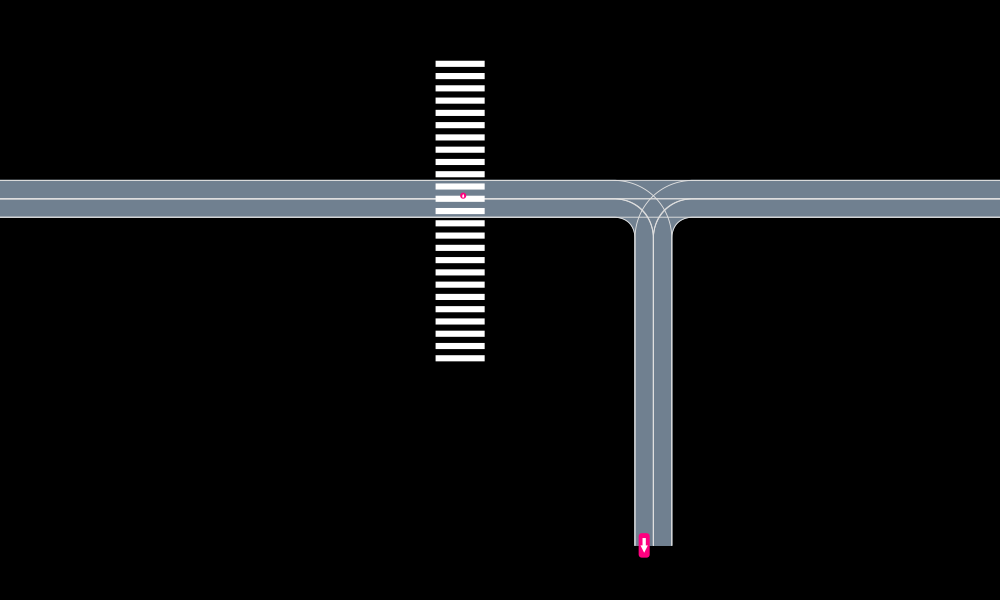

In [11]:
timestep = 0.1

models = Dict{Int, DriverModel}()
models[1] = CrosswalkDriver(LaneSpecificAccelLatLon(0.0,0.0))
models[2] = CrosswalkDriver(LaneSpecificAccelLatLon(0.0,0.0))

nticks = 100
rec = SceneRecord(nticks+1, timestep)
simulate!(rec, scene, roadway, models, nticks)
render(rec[0], env, cam=cam)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(51, nactions=1),"frame_index",51,"51",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(68=>"68",2=>"2",89=>"89",11=>"11",39=>"39",46=>"46",85=>"85",25=>"25",55=>"55",42=>"42"…)),Any[],Any[],true,"horizontal")

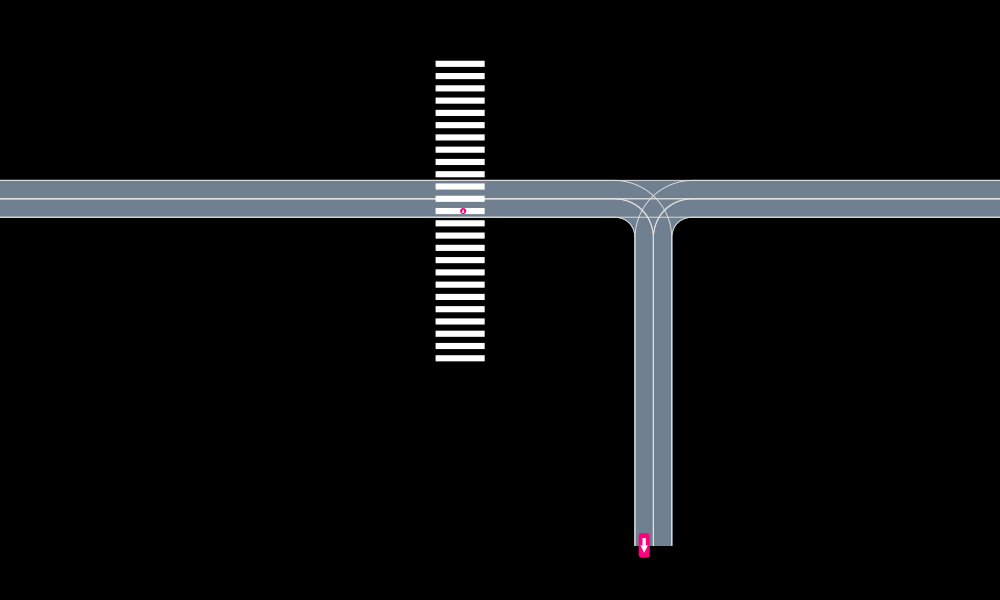

In [13]:
using Interact
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], env, cam=cam)
end